In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [174]:
df = pd.read_csv('cleaned_laptop_dataset.csv')

In [175]:
df.head()

,Brand,Price,Processor_Brand,RAM_Expandable,RAM_Size (GB),RAM_TYPE,Processer_Speed(Ghz),Display_type,GPU_Brand,SSD(GB),HDD(GB),Operating_System,Display_Tier,GPU,GPU_Tier,Processor_Tier
0,Lenovo,127011.5,AMD,Yes,8,DDR4,4.0,LCD,AMD,512.0,0,Windows 11,Large,Radeon Graphics,Entry-level,Mid-End
1,Dell,274750.0,Intel,Yes,16,DDR5,3.3,LCD,NVIDIA,512.0,0,Windows 11,Large,RTX 3050,Mid-end,Mid-End
2,Hp,194215.0,Intel,Yes,8,DDR4,4.2,LCD,Intel,512.0,0,Windows 11,Large,Iris Xe,Low-end,Mid-End
3,Infinix,76965.0,Intel,No,8,LPDDR4X,1.7,LCD,Intel,512.0,0,Windows 11,Large,UHD Graphics,Entry-level,Low-End
4,Acer,122465.0,Intel,Yes,16,DDR4,0.0,LCD,Intel,512.0,0,Windows 11,Small,Iris Xe,Low-end,Mid-End


In [176]:
le_dict = {}
for col in ['Brand', 'Processor_Brand', 'RAM_TYPE', 'Display_type', 'Operating_System', 'GPU', 'GPU_Brand']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le  # store encoder if you need to inverse transform later

In [177]:
df['RAM_Expandable'] = df['RAM_Expandable'].map({'Yes': 1, 'No': 0})

In [178]:
processor_tier_map = {
    'Low-End': 1,
    'Mid-End': 2,
    'Upper Mid-End': 3,
    'High-End': 4,
    'Apple M-Series': 5
}
df['Processor_Tier'] = df['Processor_Tier'].map(processor_tier_map)

In [179]:
gpu_tier_map = {
    'Entry-Level': 1,
    'Low-End': 2,
    'Mid-End': 3,
    'High-End': 4
}
df['GPU_Tier'] = df['GPU_Tier'].map(gpu_tier_map)

In [180]:
display_map = {
    'Small': 1,
    'Medium': 2,
    'Large': 3
}

df['Display_Tier'] = df['Display_Tier'].map(display_map)

In [181]:
X = df.drop(columns=['Price'])
y = df['Price']

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [183]:
xgb_model = XGBRegressor(
    n_estimators=5000,     # number of trees
    learning_rate=0.05,   # shrinkage step
    max_depth=8,          # tree depth
    subsample=0.8,        # row sampling
    colsample_bytree=0.8, # feature sampling
    random_state=42,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,  # NEW: can pass here
    eval_metric='rmse'          # NEW: can pass here
)

xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

print(f"Best iteration: {xgb_model.best_iteration}")

[0]	validation_0-rmse:168847.23840
[100]	validation_0-rmse:82696.71173
[190]	validation_0-rmse:82206.89044
Best iteration: 141


In [184]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 82077.0556813702
R² Score: 0.778465505284474


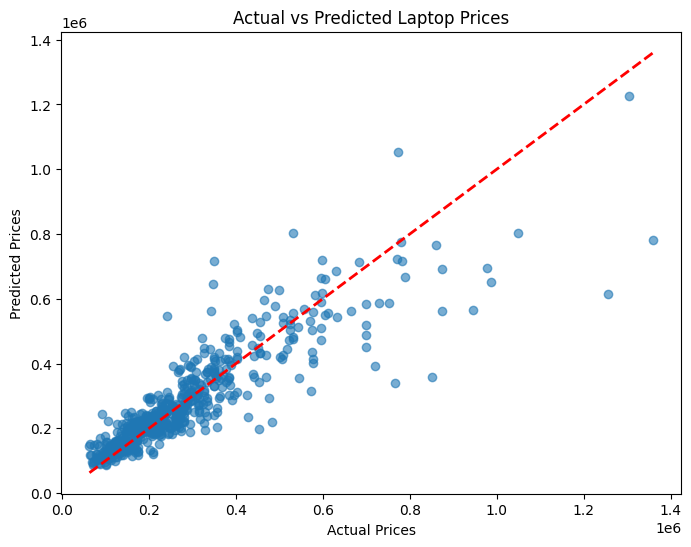

In [185]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Laptop Prices")
plt.show()

In [186]:
param_dist = {
    "n_estimators": [300, 500, 800, 1200],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3]
}


search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train, y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [4, 6, ...], ...}"
,n_iter,20
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [187]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)   # take square root manually
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 80307.05290174806
R² Score: 0.787917322086299


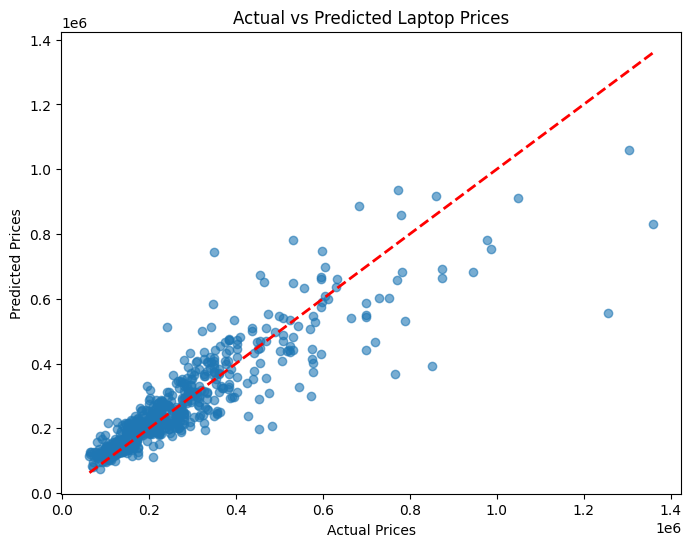

In [188]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Laptop Prices")
plt.show()

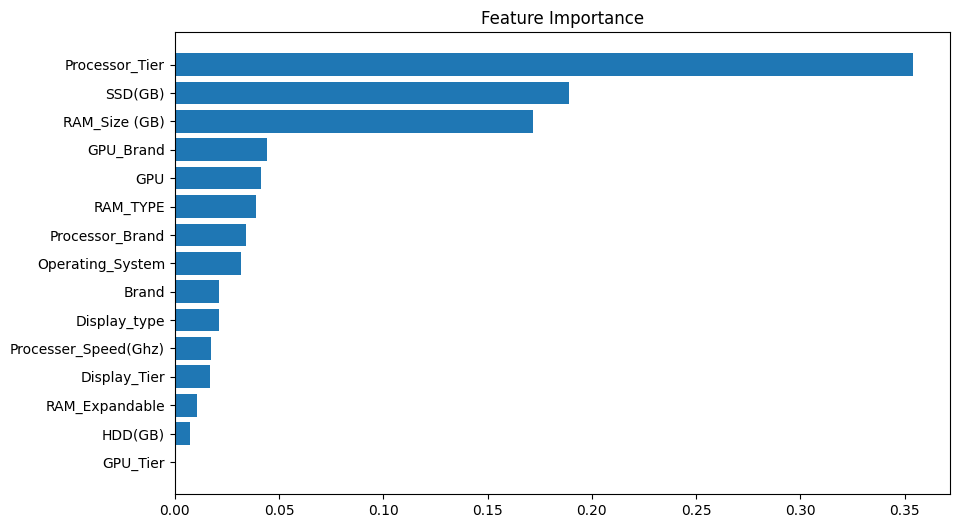

In [189]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()


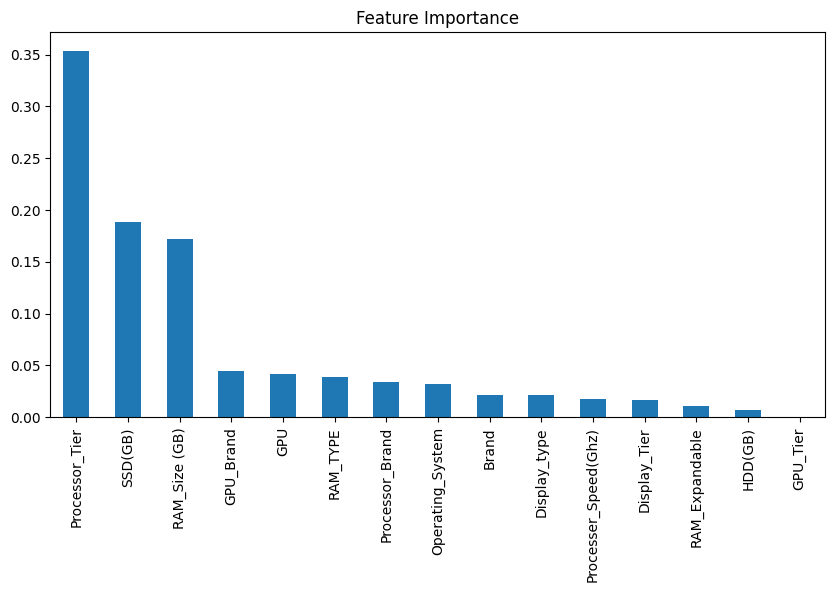

In [193]:
importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importance.plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance")
plt.show()

In [ ]:
import joblib

joblib.dump(best_model, "XgBoost_model.pkl")
print("Model saved successfully!")

In [ ]:
feature_names = X.columns.tolist()
joblib.dump(feature_names, "feature_names.pkl")
print(f"Feature names saved! Total features: {len(feature_names)}")

print("\nFeature columns:")
for i, col in enumerate(feature_names, 1):
    print(f"{i}. {col}")